In [1]:
#pip install --upgrade numpy tensorflow

In [2]:
#pip install sionna

In [3]:
# You may install the required libraries from https://nvlabs.github.io/sionna/installation.html
# or generate channel here in google colab
# ---------------------------------------------------------------------------------------------
# Load the required libraries
import numpy as np
import matplotlib.pyplot as plt

try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
from sionna.phy.channel.tr38901 import Antenna, AntennaArray, UMa, UMi, RMa
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, gen_single_sector_topology
from sionna.phy.ofdm import ResourceGrid

In [4]:
# ===========================
# 1️⃣ Define BS & UE Parameters
# ===========================
num_bs = 1  # Number of Base Stations
num_ue = 20  # Number of User Equipments   уменьшила до 20
num_ue_ant = 4  # UE MIMO Antennas
batch_size = 40  # Number of parallel simulations   уменьшила до 4
scenario = "UMa"  # Urban Macro (Can be "UMa", "UMi", "RMa")
min_bs_ut_dist = 100 # Minimum BS-UE distance in meters
ISD = 500 # Inter-Site Distance
bs_height = 25 # BS height in meters
ut_height = 1.5 # UE height in meters
UE_speed = 0.83 # UE speed in meters/second

# ===========================
# 2️⃣ Define Resource Grid
# ===========================
carrier_frequency = 3.5e9  # 2.14 or 3.5 GHz (mid-band 5G)
fft_size = 256  # FFT Size   уменьшила до 256
sc_spacing = 30e3  # Subcarrier Spacing (30 kHz for FR1)
num_ofdm_symbols = 1  # OFDM symbols per slot

# ===========================
# 3️⃣ Define Antenna Array Configurations
# ===========================
bs_array = AntennaArray(
    num_rows=4, # number of rows in BS antenna array
    num_cols=8, # number of columns in BS antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.9, # 0.9-wavelength spacing between vertical antenna elements
    horizontal_spacing=0.5 # Half-wavelength spacing between horizontal antenna elements
)

ue_array = AntennaArray(
    num_rows=1, # number of rows in UE antenna array
    num_cols=2, # number of columns in UE antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=1, # One-wavelength spacing between vertical antenna elements
    horizontal_spacing=1  # One-wavelength spacing between horizontal antenna elements
)

# ===========================
# 4️⃣ Select Channel Model
# ===========================
if scenario == "UMa":
  channel_model = UMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "UMi":
  channel_model = UMi(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "RMa":
  channel_model = RMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")

# ===========================
# 5️⃣ Set 3GPP Scenario Parameters
# ===========================
pre_topology = sionna.phy.channel.set_3gpp_scenario_parameters(
                      scenario=scenario.lower(),
                      min_bs_ut_dist=min_bs_ut_dist,  # Minimum BS-UE distance in meters
                      isd=ISD,  # Inter-Site Distance
                      bs_height=bs_height,  # BS height in meters
                      min_ut_height=ut_height,  # Minimum UE height in meters
                      max_ut_height=ut_height,  # Maximum UE height in meters
                      indoor_probability=0, # Probability of a UE to be indoor
                      min_ut_velocity=UE_speed, # ! meter/sec
                      max_ut_velocity=UE_speed)

min_bs_ut_dist, isd, bs_height, min_ut_height, max_ut_height, indoor_probability, min_ut_velocity, max_ut_velocity = pre_topology
     

-----------------------------------------------------
Size of output frequency domain channel tensor:
 batch_size = 40 
 UE number = 20 
 UE antenna number = 4 
 BS number = 1 
 BS antenna number = 64 
 number ofdm symbols = 1 
 Subcarriers number = 256
*********** Successful channel generation ***********


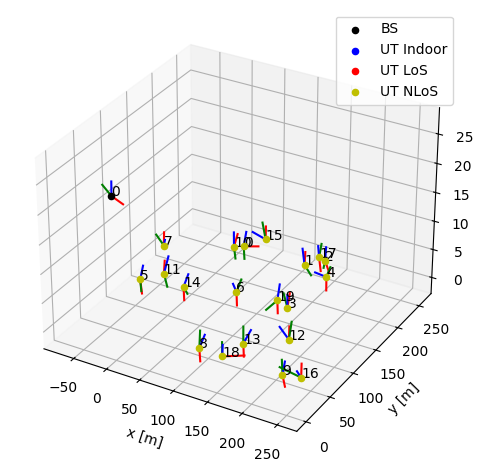

In [5]:
# ===========================
# 6️⃣ Generate Single Sector Topology
# ===========================
topology = gen_single_sector_topology(
                      batch_size=batch_size,
                      num_ut=num_ue,
                      isd=isd,
                      min_bs_ut_dist=min_bs_ut_dist,
                      scenario=scenario.lower(),
                      min_ut_height=min_ut_height,
                      max_ut_height=max_ut_height,
                      indoor_probability=indoor_probability,
                      min_ut_velocity=min_ut_velocity,
                      max_ut_velocity=max_ut_velocity)

ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology

# ===========================
# 7️⃣ Set Topology into the Channel Model
# ===========================
channel_model.set_topology(
    ut_loc,
    bs_loc,
    ut_orientations,
    bs_orientations,
    ut_velocities,
    in_state,
    los = False)# los=False=NLoS, los=True=LoS, None=LoS

channel_model.show_topology()

# ===========================
# 8️⃣ Simulate Time-Domain Channel
# ===========================
a, tau = channel_model(num_time_samples=num_ofdm_symbols,sampling_frequency=sc_spacing)  # Get channel impulse response (CIR)

# ===========================
# 9️⃣ Move Channel from Time to Frequency Domain
# ===========================
subcarrier_freqs = subcarrier_frequencies(fft_size, sc_spacing)
H_freq = cir_to_ofdm_channel(subcarrier_freqs, a, tau, normalize=True)  # Convert CIR to OFDM channel

print("-----------------------------------------------------")
print(f"Size of output frequency domain channel tensor:\n batch_size = {H_freq.shape[0]} \n UE number = {H_freq.shape[1]} \n UE antenna number = {H_freq.shape[2]} \n BS number = {H_freq.shape[3]} \n BS antenna number = {H_freq.shape[4]} \n number ofdm symbols = {H_freq.shape[5]} \n Subcarriers number = {H_freq.shape[6]}")
print("*********** Successful channel generation ***********")

# ===========================
# ✅ Output Results
# ===========================
H_freq = np.transpose(np.squeeze(H_freq),(3,2,4,1,0)) # Output channel tensor H=[N_tx x N_rx x N_sc x N_ue x N_batch]

In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [7]:
from scipy.io import savemat
savemat(f"Sionna_3GPP_{scenario.upper()}_Channel.mat", {'Hfrq': H_freq})
#from google.colab import files
#files.download(f"Sionna_3GPP_{scenario.upper()}_Channel.mat") # uncomment this to download the tensor

In [8]:
H_freq.shape

(64, 4, 256, 20, 40)

In [9]:
import scipy, ot
print('SciPy:', scipy.__version__); print('POT:', ot.__version__)

SciPy: 1.10.1
POT: 0.9.0


In [10]:
# Amplitude/phase normalization and SVD-based feature extraction

import numpy as np
from collections import Counter

try:
    import torch
except ImportError:
    torch = None

TAU_RANK_REL = 1e-3
TAU_DEGEN_REL = 1e-4

N_tx, N_rx, N_sc, N_users, N_batches = H_freq.shape
min_dim = min(N_tx, N_rx)

print(f"H_freq shape: {H_freq.shape}, min(N_tx, N_rx)={min_dim}")


def amplitude_phase_normalization(H):
    amplitude = np.abs(H)
    phase = np.angle(H)

    amp_mean = float(amplitude.mean())
    amp_std = float(amplitude.std())
    phase_mean = float(phase.mean())
    phase_std = float(phase.std())

    if amp_std < 1e-12:
        amp_std = 1.0
    if phase_std < 1e-12:
        phase_std = 1.0

    amp_norm = (amplitude - amp_mean) / amp_std
    phase_norm = (phase - phase_mean) / phase_std

    stats = {
        'amp_mean': amp_mean,
        'amp_std': amp_std,
        'phase_mean': phase_mean,
        'phase_std': phase_std,
    }
    H_norm = np.stack([amp_norm, phase_norm], axis=-1)
    return H_norm.astype(np.float32), stats


def amplitude_phase_denormalize(H_norm, stats):
    amp_norm = H_norm[..., 0]
    phase_norm = H_norm[..., 1]
    amplitude = amp_norm * stats['amp_std'] + stats['amp_mean']
    phase = phase_norm * stats['phase_std'] + stats['phase_mean']
    return amplitude * np.exp(1j * phase)



def complex_to_amp_phase_features(H_complex, metadata):
    """
    Convert complex channel samples to normalized amplitude/phase features
    using precomputed dataset statistics.
    """
    if torch is not None and isinstance(H_complex, torch.Tensor):
        H_complex = H_complex.detach().cpu().numpy()
    else:
        H_complex = np.asarray(H_complex)
    stats = metadata['norm_stats']
    amp_mean = stats['amp_mean']
    amp_std = stats['amp_std'] if abs(stats['amp_std']) >= 1e-12 else 1.0
    phase_mean = stats['phase_mean']
    phase_std = stats['phase_std'] if abs(stats['phase_std']) >= 1e-12 else 1.0

    amplitude = np.abs(H_complex)
    phase = np.angle(H_complex)
    amp_norm = (amplitude - amp_mean) / amp_std
    phase_norm = (phase - phase_mean) / phase_std

    H_norm = np.stack([amp_norm, phase_norm], axis=-1)  # [B, N_tx, N_rx, N_sc, 2]
    H_norm = np.moveaxis(H_norm, -1, 1)  # [B, 2, N_tx, N_rx, N_sc]
    B, two, n_tx, n_rx, n_sc = H_norm.shape
    return H_norm.reshape(B, two * n_tx * n_rx, n_sc).astype(np.float32)


H_norm, amp_phase_stats = amplitude_phase_normalization(H_freq)
amp_phase_feature_tensor = np.zeros((N_users * N_batches, 2 * N_tx * N_rx, N_sc), dtype=np.float32)

for u_idx in range(N_users):
    for b_idx in range(N_batches):
        sample_idx = u_idx * N_batches + b_idx
        block = H_norm[:, :, :, u_idx, b_idx, :]  # [N_tx, N_rx, N_sc, 2]
        block = np.moveaxis(block, -1, 0)  # [2, N_tx, N_rx, N_sc]
        amp_phase_feature_tensor[sample_idx] = block.reshape(2 * N_tx * N_rx, N_sc)

amp_phase_metadata = {
    'N_tx': N_tx,
    'N_rx': N_rx,
    'N_sc': N_sc,
    'N_users': N_users,
    'N_batches': N_batches,
    'feature_channels': amp_phase_feature_tensor.shape[1],
    'sequence_length': N_sc,
    'norm_stats': amp_phase_stats,
    'sample_order': 'user-major (user*batches)',
}

print("Constructed amplitude/phase feature tensor:")
print(f"samples={amp_phase_feature_tensor.shape[0]}, channels={amp_phase_feature_tensor.shape[1]}, sequence_length={amp_phase_feature_tensor.shape[2]}")


H_slices = H_freq.transpose(3, 4, 2, 0, 1)

svd_U = np.zeros((N_users, N_batches, N_sc, N_tx, min_dim), dtype=np.complex64)
svd_V = np.zeros((N_users, N_batches, N_sc, N_rx, min_dim), dtype=np.complex64)
svd_S = np.zeros((N_users, N_batches, N_sc, min_dim), dtype=np.float32)
svd_rank = np.zeros((N_users, N_batches, N_sc), dtype=np.int16)

rank_values = []
rank_counter = Counter()
degeneracy_counter = Counter()


def _normalize_pair(u_col, v_col, eps=1e-8):
    u_col = np.asarray(u_col, dtype=np.complex64).copy()
    v_col = np.asarray(v_col, dtype=np.complex64).copy()
    u_norm = np.linalg.norm(u_col)
    if u_norm > eps:
        u_col /= u_norm
    v_norm = np.linalg.norm(v_col)
    if v_norm > eps:
        v_col /= v_norm
    pivot_indices = np.where(np.abs(u_col) > eps)[0]
    pivot_value = None
    if pivot_indices.size:
        pivot_value = u_col[pivot_indices[0]]
    else:
        pivot_indices = np.where(np.abs(v_col) > eps)[0]
        if pivot_indices.size:
            pivot_value = v_col[pivot_indices[0]]
    if pivot_value is not None:
        phase = np.exp(-1j * np.angle(pivot_value))
        u_col *= phase
        v_col *= phase
    return u_col, v_col


for u_idx in range(N_users):
    for b_idx in range(N_batches):
        for sc_idx in range(N_sc):
            mat = H_slices[u_idx, b_idx, sc_idx]
            U, S, Vh = np.linalg.svd(mat, full_matrices=False)
            V = Vh.conj().T

            for col in range(min_dim):
                u_col, v_col = _normalize_pair(U[:, col], V[:, col])
                U[:, col] = u_col
                V[:, col] = v_col

            svd_U[u_idx, b_idx, sc_idx] = U[:, :min_dim].astype(np.complex64)
            svd_V[u_idx, b_idx, sc_idx] = V[:, :min_dim].astype(np.complex64)
            svd_S[u_idx, b_idx, sc_idx] = S.astype(np.float32)

            denom = S[0] if S.size else 0.0
            rel = S / (denom + 1e-12) if denom > 0 else np.zeros_like(S)
            effective_rank = int((rel > TAU_RANK_REL).sum())
            if effective_rank == 0 and S.size:
                effective_rank = 1
            rank_values.append(effective_rank)
            rank_counter[effective_rank] += 1
            svd_rank[u_idx, b_idx, sc_idx] = effective_rank

            groups = []
            if S.size:
                start = 0
                for idx in range(S.size - 1):
                    gap = abs(S[idx] - S[idx + 1])
                    denom_gap = max(abs(S[idx]), 1e-12)
                    if gap / denom_gap > TAU_DEGEN_REL:
                        groups.append(idx - start + 1)
                        start = idx + 1
                groups.append(S.size - start)
            else:
                groups.append(0)
            for g in groups:
                degeneracy_counter[g] += 1

rank_array = np.array(rank_values, dtype=np.int16)
if rank_array.size:
    rank_mode = rank_counter.most_common(1)[0]
    print(f"Total matrices analysed: {rank_array.size}")
    print(f"Rank stats -> min: {rank_array.min()}, max: {rank_array.max()}, mean: {rank_array.mean():.2f}, median: {np.median(rank_array):.2f}")
    print(f"Most common rank: {rank_mode[0]} (count={rank_mode[1]})")
    print("Rank histogram:", {k: rank_counter[k] for k in sorted(rank_counter)})
    print("Degeneracy group size counts:", {k: degeneracy_counter[k] for k in sorted(degeneracy_counter)})
else:
    print("No matrices processed for SVD statistics.")


K_TRUNC = min_dim  # adjust after inspecting the statistics above
ALLOW_ZERO_PADDING = True

num_samples = N_users * N_batches
sequence_length = N_sc
channels_per_mode = 4 * (N_tx + N_rx) + 1

amp_u = np.zeros((num_samples, sequence_length, K_TRUNC, N_tx), dtype=np.float32)
phase_u = np.zeros_like(amp_u)
amp_v = np.zeros((num_samples, sequence_length, K_TRUNC, N_rx), dtype=np.float32)
phase_v = np.zeros_like(amp_v)
sigma_raw = np.zeros((num_samples, sequence_length, K_TRUNC), dtype=np.float32)
sigma_valid = np.zeros_like(sigma_raw, dtype=bool)
sample_short_rank = np.zeros(num_samples, dtype=bool)

for u_idx in range(N_users):
    for b_idx in range(N_batches):
        sample_idx = u_idx * N_batches + b_idx
        for sc_idx in range(N_sc):
            singular_values = svd_S[u_idx, b_idx, sc_idx]
            U_block = svd_U[u_idx, b_idx, sc_idx]
            V_block = svd_V[u_idx, b_idx, sc_idx]
            take = min(K_TRUNC, singular_values.size)
            if take < K_TRUNC:
                sample_short_rank[sample_idx] = True
            if take == 0:
                continue
            amp_u[sample_idx, sc_idx, :take, :] = np.abs(U_block[:, :take].T)
            phase_u[sample_idx, sc_idx, :take, :] = np.angle(U_block[:, :take].T)
            amp_v[sample_idx, sc_idx, :take, :] = np.abs(V_block[:, :take].T)
            phase_v[sample_idx, sc_idx, :take, :] = np.angle(V_block[:, :take].T)
            sigma_raw[sample_idx, sc_idx, :take] = singular_values[:take]
            sigma_valid[sample_idx, sc_idx, :take] = True

if not ALLOW_ZERO_PADDING and sample_short_rank.any():
    missing = int(sample_short_rank.sum())
    raise ValueError(f"K_TRUNC={K_TRUNC} exceeds the minimal rank for {missing} samples; set ALLOW_ZERO_PADDING=True or reduce K_TRUNC.")

sigma_values = sigma_raw[sigma_valid]
if sigma_values.size:
    sigma_mean = float(sigma_values.mean())
    sigma_std = float(sigma_values.std())
else:
    sigma_mean = 0.0
    sigma_std = 1.0
if sigma_std < 1e-12:
    sigma_std = 1.0
sigma_z = np.zeros_like(sigma_raw, dtype=np.float32)
if sigma_values.size:
    sigma_z[sigma_valid] = (sigma_raw[sigma_valid] - sigma_mean) / sigma_std
sigma_padding_token = float((0.0 - sigma_mean) / sigma_std)
sigma_z[~sigma_valid] = sigma_padding_token


def _flatten_feature_block(arr):
    arr = arr.transpose(0, 2, 3, 1)
    batch, modes, features, seq = arr.shape
    return arr.reshape(batch, modes * features, seq)


amp_u_block = _flatten_feature_block(amp_u)
phase_u_block = _flatten_feature_block(phase_u)
amp_v_block = _flatten_feature_block(amp_v)
phase_v_block = _flatten_feature_block(phase_v)
sigma_block = _flatten_feature_block(sigma_z[..., None])

svd_feature_tensor = np.concatenate(
    [amp_u_block, phase_u_block, amp_v_block, phase_v_block, sigma_block],
    axis=1,
).astype(np.float32)

feature_channels = svd_feature_tensor.shape[1]
sequence_length = svd_feature_tensor.shape[2]

padding_fraction = sample_short_rank.sum() / num_samples if num_samples else 0.0
print(f"Constructed SVD feature tensor: samples={num_samples}, channels={feature_channels}, sequence_length={sequence_length}")
print(f"K_TRUNC={K_TRUNC}, zero-padding enabled={ALLOW_ZERO_PADDING}, samples requiring padding={sample_short_rank.sum()} ({padding_fraction:.2%})")
print(f"Singular value normalization: mean={sigma_mean:.4f}, std={sigma_std:.4f}, padding token={sigma_padding_token:.4f}")

svd_summary = {
    'tau_rank_rel': TAU_RANK_REL,
    'tau_degen_rel': TAU_DEGEN_REL,
    'rank_hist': dict(rank_counter),
    'degeneracy_hist': dict(degeneracy_counter),
    'rank_array': rank_array,
}

svd_feature_metadata = {
    'K_TRUNC': K_TRUNC,
    'ALLOW_ZERO_PADDING': ALLOW_ZERO_PADDING,
    'sigma_mean': sigma_mean,
    'sigma_std': sigma_std,
    'sigma_padding_token': sigma_padding_token,
    'N_tx': N_tx,
    'N_rx': N_rx,
    'N_sc': N_sc,
    'N_users': N_users,
    'N_batches': N_batches,
    'channels_per_mode': channels_per_mode,
    'feature_channels': feature_channels,
    'sequence_length': sequence_length,
    'tau_rank_rel': TAU_RANK_REL,
    'tau_degen_rel': TAU_DEGEN_REL,
    'padding_fraction': padding_fraction,
    'rank_hist': dict(rank_counter),
    'degeneracy_hist': dict(degeneracy_counter),
    'min_rank': int(rank_array.min()) if rank_array.size else 0,
    'max_rank': int(rank_array.max()) if rank_array.size else 0,
    'mean_rank': float(rank_array.mean()) if rank_array.size else 0.0,
    'total_matrices': int(rank_array.size),
}
svd_feature_metadata['svd_summary'] = svd_summary
svd_feature_metadata['samples_requiring_padding'] = sample_short_rank.astype(np.bool_)

feature_block_sizes = {
    'amp_u': N_tx,
    'phase_u': N_tx,
    'amp_v': N_rx,
    'phase_v': N_rx,
    'sigma': 1,
}
svd_feature_metadata['block_sizes'] = feature_block_sizes

# Legacy alias for compatibility with earlier cells
data_features = svd_feature_tensor


def unpack_feature_tensor(feature_tensor, metadata, denormalize_sigma=False):
    if torch is not None and isinstance(feature_tensor, torch.Tensor):
        arr = feature_tensor.detach().cpu().numpy()
    else:
        arr = np.asarray(feature_tensor)
    if arr.ndim != 3:
        raise ValueError(f"Expected feature tensor with 3 dims, got shape {arr.shape}")
    batch, channels, seq = arr.shape
    K = metadata['K_TRUNC']
    sizes = metadata['block_sizes']
    offset = 0

    def _extract(size):
        nonlocal offset
        block = arr[:, offset:offset + K * size, :]
        offset += K * size
        block = block.reshape(batch, K, size, seq).transpose(0, 3, 1, 2)
        return block

    amp_u_local = _extract(sizes['amp_u'])
    phase_u_local = _extract(sizes['phase_u'])
    amp_v_local = _extract(sizes['amp_v'])
    phase_v_local = _extract(sizes['phase_v'])
    sigma_block_local = _extract(sizes['sigma'])[..., 0]

    sigma_z_local = sigma_block_local
    sigma_local = sigma_z_local
    if denormalize_sigma:
        sigma_local = sigma_z_local * metadata['sigma_std'] + metadata['sigma_mean']
        padding_mask = np.isclose(sigma_z_local, metadata['sigma_padding_token'], atol=1e-4)
        sigma_local = np.where(padding_mask, 0.0, sigma_local)
    return {
        'amp_u': amp_u_local.astype(np.float32),
        'phase_u': phase_u_local.astype(np.float32),
        'amp_v': amp_v_local.astype(np.float32),
        'phase_v': phase_v_local.astype(np.float32),
        'sigma_z': sigma_z_local.astype(np.float32),
        'sigma': sigma_local.astype(np.float32) if denormalize_sigma else None,
    }


def features_to_svd_components(feature_tensor, metadata, denormalize_sigma=True, enforce_unit_norm=True):
    components = unpack_feature_tensor(feature_tensor, metadata, denormalize_sigma=denormalize_sigma)
    amp_u_local = components['amp_u']
    phase_u_local = components['phase_u']
    amp_v_local = components['amp_v']
    phase_v_local = components['phase_v']

    U = amp_u_local * np.exp(1j * phase_u_local)
    V = amp_v_local * np.exp(1j * phase_v_local)

    if enforce_unit_norm:
        eps = 1e-8
        U = U / np.maximum(np.linalg.norm(U, axis=-1, keepdims=True), eps)
        V = V / np.maximum(np.linalg.norm(V, axis=-1, keepdims=True), eps)

    if denormalize_sigma:
        sigma = components['sigma']
        if sigma is None:
            raise ValueError("Sigma values are not available; set denormalize_sigma=True in unpack_feature_tensor.")
    else:
        sigma = components['sigma_z']
    return {
        'U': U.astype(np.complex64),
        'V': V.astype(np.complex64),
        'sigma': sigma.astype(np.float32),
    }


def reconstruct_channel_from_features(feature_tensor, metadata):
    comps = features_to_svd_components(feature_tensor, metadata, denormalize_sigma=True, enforce_unit_norm=True)
    U = comps['U']  # [B, seq, K, N_tx]
    V = comps['V']  # [B, seq, K, N_rx]
    sigma = np.clip(comps['sigma'], 0.0, None)  # [B, seq, K]
    H_rec = np.einsum('bskn,bskm,bsk->bnms', U, np.conjugate(V), sigma, optimize=True)
    return H_rec.astype(np.complex64)


def amp_phase_features_to_complex(feature_tensor, metadata):
    stats = metadata['norm_stats']
    if torch is not None and isinstance(feature_tensor, torch.Tensor):
        arr = feature_tensor.detach().cpu().numpy()
    else:
        arr = np.asarray(feature_tensor)
    if arr.ndim != 3:
        raise ValueError(f"Expected feature tensor with 3 dims, got shape {arr.shape}")
    batch, channels, seq = arr.shape
    expected_channels = 2 * metadata['N_tx'] * metadata['N_rx']
    if channels != expected_channels or seq != metadata['N_sc']:
        raise ValueError(f"Unexpected feature tensor shape {arr.shape}, expected ({batch}, {expected_channels}, {metadata['N_sc']})")
    arr = arr.reshape(batch, 2, metadata['N_tx'], metadata['N_rx'], seq)
    arr = np.moveaxis(arr, 1, -1)  # [B, N_tx, N_rx, seq, 2]
    complex_denorm = amplitude_phase_denormalize(arr, stats)
    return complex_denorm.astype(np.complex64)


def complex_to_svd_feature_tensor(H_complex, metadata):
    if torch is not None and isinstance(H_complex, torch.Tensor):
        H_complex = H_complex.detach().cpu().numpy()
    else:
        H_complex = np.asarray(H_complex)
    if H_complex.ndim != 4:
        raise ValueError(f"Expected complex tensor with 4 dims [B, N_tx, N_rx, N_sc], got {H_complex.shape}")
    num_samples, N_tx_local, N_rx_local, N_sc_local = H_complex.shape
    if (N_tx_local, N_rx_local, N_sc_local) != (metadata['N_tx'], metadata['N_rx'], metadata['N_sc']):
        raise ValueError("Input dimensions do not match metadata")

    K = metadata['K_TRUNC']
    sigma_mean = metadata['sigma_mean']
    sigma_std = metadata['sigma_std'] if metadata['sigma_std'] >= 1e-12 else 1.0
    sigma_padding_token = metadata['sigma_padding_token']

    amp_u_tmp = np.zeros((num_samples, N_sc_local, K, N_tx_local), dtype=np.float32)
    phase_u_tmp = np.zeros_like(amp_u_tmp)
    amp_v_tmp = np.zeros((num_samples, N_sc_local, K, N_rx_local), dtype=np.float32)
    phase_v_tmp = np.zeros_like(amp_v_tmp)
    sigma_z_tmp = np.full((num_samples, N_sc_local, K), sigma_padding_token, dtype=np.float32)

    for sample_idx in range(num_samples):
        for sc_idx in range(N_sc_local):
            mat = H_complex[sample_idx, :, :, sc_idx]
            U, S, Vh = np.linalg.svd(mat, full_matrices=False)
            V = Vh.conj().T
            take = min(K, S.size)
            for col in range(take):
                u_col, v_col = _normalize_pair(U[:, col], V[:, col])
                U[:, col] = u_col
                V[:, col] = v_col
            if take:
                amp_u_tmp[sample_idx, sc_idx, :take] = np.abs(U[:, :take].T)
                phase_u_tmp[sample_idx, sc_idx, :take] = np.angle(U[:, :take].T)
                amp_v_tmp[sample_idx, sc_idx, :take] = np.abs(V[:, :take].T)
                phase_v_tmp[sample_idx, sc_idx, :take] = np.angle(V[:, :take].T)
                sigma_z_tmp[sample_idx, sc_idx, :take] = (S[:take] - sigma_mean) / sigma_std

    amp_block = _flatten_feature_block(amp_u_tmp)
    phase_u_block = _flatten_feature_block(phase_u_tmp)
    amp_v_block = _flatten_feature_block(amp_v_tmp)
    phase_v_block = _flatten_feature_block(phase_v_tmp)
    sigma_block = _flatten_feature_block(sigma_z_tmp[..., None])
    features = np.concatenate([amp_block, phase_u_block, amp_v_block, phase_v_block, sigma_block], axis=1)
    return features.astype(np.float32)


def flatten_feature_tensor_for_swd(feature_tensor, max_points=200_000, seed=0):
    if torch is not None and isinstance(feature_tensor, torch.Tensor):
        arr = feature_tensor.detach().cpu().numpy()
    else:
        arr = np.asarray(feature_tensor)
    arr = np.transpose(arr, (0, 2, 1))  # [batch, seq, channels]
    arr = arr.reshape(-1, arr.shape[-1])
    total = arr.shape[0]
    if max_points is not None and total > max_points:
        rng = np.random.default_rng(seed)
        idx = rng.choice(total, size=max_points, replace=False)
        arr = arr[idx]
    return arr.astype(np.float64)


# Release intermediate arrays that are no longer needed
# (retain svd_U / svd_V / svd_S if further analysis is required)
del amp_u, phase_u, amp_v, phase_v, sigma_raw, sigma_valid, sigma_z, sample_short_rank

H_freq shape: (64, 4, 256, 20, 40), min(N_tx, N_rx)=4
Constructed amplitude/phase feature tensor:
samples=800, channels=512, sequence_length=256
Total matrices analysed: 204800
Rank stats -> min: 4, max: 4, mean: 4.00, median: 4.00
Most common rank: 4 (count=204800)
Rank histogram: {4: 204800}
Degeneracy group size counts: {1: 819200}
Constructed SVD feature tensor: samples=800, channels=548, sequence_length=256
K_TRUNC=4, zero-padding enabled=True, samples requiring padding=0 (0.00%)
Singular value normalization: mean=7.1399, std=3.6086, padding token=-1.9786


In [11]:
import torch
import torch.nn as nn


class TimeCondConvNet1D(nn.Module):
    def __init__(self, in_channels, base_dim=128, num_layers=4, kernel_size=5):
        super().__init__()
        assert num_layers >= 1, "num_layers must be >= 1"
        self.in_channels = in_channels
        self.base_dim = base_dim
        self.kernel_size = kernel_size
        self.time_embed = nn.Sequential(
            nn.Linear(1, base_dim),
            nn.SiLU(),
            nn.Linear(base_dim, base_dim),
            nn.SiLU(),
        )

        conv_blocks = []
        for layer_idx in range(num_layers):
            in_dim = base_dim if layer_idx > 0 else in_channels + base_dim
            conv_blocks.append(
                nn.Conv1d(
                    in_dim,
                    base_dim,
                    kernel_size,
                    padding=kernel_size // 2,
                )
            )
            conv_blocks.append(nn.GroupNorm(8, base_dim))
            conv_blocks.append(nn.SiLU())
        conv_blocks.append(
            nn.Conv1d(
                base_dim,
                in_channels,
                kernel_size,
                padding=kernel_size // 2,
            )
        )
        self.net = nn.Sequential(*conv_blocks)

    def forward(self, x, t):
        # x: [B, C, L], t: [B] or [B, 1]
        B, _, L = x.shape
        if t.ndim == 1:
            t = t[:, None]
        t_embed = self.time_embed(t).unsqueeze(-1).expand(-1, -1, L)
        x_in = torch.cat([x, t_embed], dim=1)
        return self.net(x_in)


class TimeCondMLP(nn.Module):
    def __init__(self, in_channels, length, hidden_dim=512, num_layers=3):
        super().__init__()
        assert num_layers >= 1, "num_layers must be >= 1"
        self.in_channels = in_channels
        self.length = length
        self.hidden_dim = hidden_dim
        input_dim = in_channels * length

        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
        )

        layers = []
        current_dim = input_dim + hidden_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.SiLU())
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, input_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        B, C, L = x.shape
        x_flat = x.view(B, C * L)
        if t.ndim == 1:
            t = t[:, None]
        t_embed = self.time_embed(t)
        x_in = torch.cat([x_flat, t_embed], dim=1)
        out = self.net(x_in)
        return out.view(B, C, L)


DEFAULT_CONV_KWARGS = {'base_dim': 128, 'num_layers': 4, 'kernel_size': 5}
DEFAULT_MLP_KWARGS = {'hidden_dim': 512, 'num_layers': 3}


def build_model(model_type, in_channels, length, conv_kwargs=None, mlp_kwargs=None):
    model_type = model_type.lower()
    conv_params = DEFAULT_CONV_KWARGS.copy()
    if conv_kwargs:
        conv_params.update(conv_kwargs)
    mlp_params = DEFAULT_MLP_KWARGS.copy()
    if mlp_kwargs:
        mlp_params.update(mlp_kwargs)
    if model_type == 'conv1d':
        return TimeCondConvNet1D(in_channels, **conv_params)
    if model_type == 'mlp':
        return TimeCondMLP(in_channels, length, **mlp_params)
    raise ValueError(f"Unsupported model_type='{model_type}'. Use 'conv1d' or 'mlp'.")

In [12]:
# Dataloader

from torch.utils.data import DataLoader, TensorDataset
import torch

TRAIN_SPACE = 'svd'  # 'svd' or 'amp_phase'
TRAIN_SPACE = TRAIN_SPACE.lower()
if TRAIN_SPACE not in {'svd', 'amp_phase'}:
    raise ValueError(f"Unsupported TRAIN_SPACE='{TRAIN_SPACE}'. Use 'svd' or 'amp_phase'.")

if TRAIN_SPACE == 'svd':
    train_features_np = svd_feature_tensor.astype(np.float32, copy=False)
    train_feature_metadata = svd_feature_metadata
else:
    train_features_np = amp_phase_feature_tensor.astype(np.float32, copy=False)
    train_feature_metadata = amp_phase_metadata

train_tensor = torch.from_numpy(train_features_np)

dataset = TensorDataset(train_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

feature_channels = train_tensor.shape[1]
sequence_length = train_tensor.shape[2]

print(f"Training space: {TRAIN_SPACE}; batches={len(dataloader)}; tensor shape={train_tensor.shape}")

svd_feature_tensor_torch = torch.from_numpy(svd_feature_tensor.astype(np.float32, copy=False))

data_tensor = train_tensor  # backward compatibility
current_feature_metadata = train_feature_metadata

Training space: svd; batches=100; tensor shape=torch.Size([800, 548, 256])


In [13]:
from diffusers import DDPMScheduler, DDIMScheduler
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

MODEL_TYPE = 'conv1d'  # 'conv1d' or 'mlp'
CONV_MODEL_KWARGS = {'base_dim': 128, 'num_layers': 4, 'kernel_size': 5}
MLP_MODEL_KWARGS = {'hidden_dim': 512, 'num_layers': 3}

model = build_model(
    MODEL_TYPE,
    feature_channels,
    sequence_length,
    conv_kwargs=CONV_MODEL_KWARGS,
    mlp_kwargs=MLP_MODEL_KWARGS,
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
num_epochs = 1000
lr = 1e-3

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

optimizer = Adam(model.parameters(), lr=lr)


model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        batch = batch[0].to(device)
        
        noise = torch.randn_like(batch)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                (batch.size(0),), device=device)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy, timesteps.float())
        
        loss = F.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")

Device: cuda
Model parameters: 1,047,972
Epoch 1, Average Loss: 1.004439
Epoch 2, Average Loss: 1.000744
Epoch 3, Average Loss: 1.000689
Epoch 4, Average Loss: 1.000287
Epoch 5, Average Loss: 1.000425
Epoch 6, Average Loss: 1.000441
Epoch 7, Average Loss: 1.000533
Epoch 8, Average Loss: 1.000223
Epoch 9, Average Loss: 1.000267
Epoch 10, Average Loss: 1.000287
Epoch 11, Average Loss: 1.001739
Epoch 12, Average Loss: 1.000128
Epoch 13, Average Loss: 0.999946
Epoch 14, Average Loss: 1.000121
Epoch 15, Average Loss: 0.999862
Epoch 16, Average Loss: 0.999849
Epoch 17, Average Loss: 1.000065
Epoch 18, Average Loss: 1.000080
Epoch 19, Average Loss: 1.000156
Epoch 20, Average Loss: 1.000133
Epoch 21, Average Loss: 1.000103
Epoch 22, Average Loss: 0.999991
Epoch 23, Average Loss: 1.000130
Epoch 24, Average Loss: 1.000112
Epoch 25, Average Loss: 1.000182
Epoch 26, Average Loss: 1.000106
Epoch 27, Average Loss: 0.999960
Epoch 28, Average Loss: 1.000006
Epoch 29, Average Loss: 1.000077
Epoch 30, A

In [14]:
def generate_samples(model, scheduler, num_samples, data_shape, device):#num_inference_steps=200 не для всех расписаний, для DDPMScheduler оно не обязательно
    model.eval()
    #scheduler.set_timesteps(num_inference_steps, device=device)#это убираем если не надо

    x = torch.randn(num_samples, *data_shape, device=device)
    
    for t in scheduler.timesteps:
        with torch.no_grad():
            timesteps = torch.full((num_samples,), t, device=device)
            noise_pred = model(x, timesteps.float())
        
        x = scheduler.step(noise_pred, t, x).prev_sample
    
    return x

data_shape = (512, 256)
generated_data = generate_samples(model, noise_scheduler, 100, data_shape, device)

RuntimeError: Given groups=1, weight of size [128, 676, 5], expected input[100, 640, 256] to have 676 channels, but got 640 channels instead

In [15]:
generated_np = generated_data.cpu().numpy()
    
# Reverse permutation [batch, channels, depth, height, width] -> [batch, height, width, depth, channels]
#generated_np = generated_np.transpose(0, 3, 4, 2, 1)

    
#print(f"Original shape: {H_flat.shape}")
print(f"Reconstructed shape: {generated_np.shape}")

Reconstructed shape: (100, 512, 256)


In [16]:
# Sampling SB-SDE & inverse reconstruction utilities

import numpy as np

num_eval_samples = 100
generated_features = generate_samples(
    model,
    noise_scheduler,
    num_samples=num_eval_samples,
    data_shape=(feature_channels, sequence_length),
    device=device,
)

orig_feature_subset = data_tensor[:generated_features.shape[0]].to(device)
orig_svd_features = svd_feature_tensor_torch[:generated_features.shape[0]]
orig_svd_features_cpu = orig_svd_features.detach().cpu()

if TRAIN_SPACE == 'svd':
    generated_complex = reconstruct_channel_from_features(generated_features, svd_feature_metadata)
    original_complex = reconstruct_channel_from_features(orig_feature_subset, svd_feature_metadata)
    generated_svd_features = generated_features
    generated_amp_np = complex_to_amp_phase_features(generated_complex, amp_phase_metadata)
    gen_amp_features = torch.from_numpy(generated_amp_np)
else:
    generated_complex = amp_phase_features_to_complex(generated_features, amp_phase_metadata)
    original_complex = amp_phase_features_to_complex(orig_feature_subset, amp_phase_metadata)
    generated_svd_np = complex_to_svd_feature_tensor(generated_complex, svd_feature_metadata)
    generated_svd_features = torch.from_numpy(generated_svd_np).to(device)
    gen_amp_features = generated_features

generated_svd_features_cpu = generated_svd_features.detach().cpu().float()
if isinstance(gen_amp_features, torch.Tensor):
    gen_amp_features_cpu = gen_amp_features.detach().cpu().float()
else:
    gen_amp_features_cpu = torch.from_numpy(np.asarray(gen_amp_features, dtype=np.float32))

orig_amp_np = amp_phase_feature_tensor[:generated_features.shape[0]].astype(np.float32)
orig_amp_features_for_metrics = torch.from_numpy(orig_amp_np).float()
orig_svd_features_for_metrics = orig_svd_features_cpu
gen_svd_features_for_metrics = generated_svd_features_cpu
gen_amp_features_for_metrics = gen_amp_features_cpu

print('Generated SVD feature tensor:', generated_svd_features_cpu.shape)
print('Generated amp/phase feature tensor:', gen_amp_features_for_metrics.shape)
print('Reconstructed complex channel from generated samples:', generated_complex.shape)
print('Reference complex channel tensor:', original_complex.shape)


Generated feature tensor: torch.Size([100, 512, 256])
Reconstructed complex channel from generated samples: (100, 64, 4, 256)
Reference complex channel tensor: (100, 64, 4, 256)


In [17]:
# Metrics in feature space: sliced wasserstein and statistics

import numpy as np
import torch
import ot
from ot.sliced import sliced_wasserstein_distance

orig_features_for_metrics = orig_svd_features_for_metrics
gen_features_for_metrics = gen_svd_features_for_metrics

X = flatten_feature_tensor_for_swd(orig_features_for_metrics, max_points=200000, seed=0)
Y = flatten_feature_tensor_for_swd(gen_features_for_metrics, max_points=200000, seed=1)

swd = sliced_wasserstein_distance(X, Y, n_projections=128, p=1, seed=42)
print(f"Sliced Wasserstein distance (SVD feature space, W1): {swd:.6f}")

real_components = unpack_feature_tensor(orig_features_for_metrics, svd_feature_metadata, denormalize_sigma=True)
gen_components = unpack_feature_tensor(gen_features_for_metrics, svd_feature_metadata, denormalize_sigma=True)


def _print_stats(label, array):
    vals = np.asarray(array).reshape(-1)
    vals = vals[np.isfinite(vals)]
    if vals.size:
        print(f"{label} -> mean={vals.mean():.4f}, std={vals.std():.4f}, min={vals.min():.4f}, max={vals.max():.4f}")
    else:
        print(f"{label} -> no valid entries")


sigma_real = real_components['sigma']
sigma_gen = gen_components['sigma']
sigma_real_masked = sigma_real[sigma_real > 0]
sigma_gen_masked = sigma_gen[sigma_gen > 0]
_print_stats('Sigma (real, denormalized)', sigma_real_masked)
_print_stats('Sigma (generated, denormalized)', sigma_gen_masked)

_print_stats('amp(U) real', real_components['amp_u'])
_print_stats('amp(U) generated', gen_components['amp_u'])
_print_stats('phase(U) real', real_components['phase_u'])
_print_stats('phase(U) generated', gen_components['phase_u'])
_print_stats('amp(V) real', real_components['amp_v'])
_print_stats('amp(V) generated', gen_components['amp_v'])
_print_stats('phase(V) real', real_components['phase_v'])
_print_stats('phase(V) generated', gen_components['phase_v'])

# Optional amp/phase metrics for reference
orig_amp = orig_amp_features_for_metrics
gen_amp = gen_amp_features_for_metrics
amp_X = flatten_feature_tensor_for_swd(orig_amp, max_points=200000, seed=10)
amp_Y = flatten_feature_tensor_for_swd(gen_amp, max_points=200000, seed=11)
amp_swd = sliced_wasserstein_distance(amp_X, amp_Y, n_projections=128, p=1, seed=47)
print(f"Sliced Wasserstein distance (amp/phase space, W1): {amp_swd:.6f}")


Sliced Wasserstein distance (feature space, W1): 0.218433


ValueError: cannot reshape array of size 0 into shape (100,4,4,256)

In [18]:
# NFE sweep: sigma std & sliced Wasserstein vs steps

import numpy as np
import torch
import matplotlib.pyplot as plt
from ot.sliced import sliced_wasserstein_distance


def sweep_nfe_and_metrics(
        steps_list=(5, 10, 20, 40, 80, 160),
        num_samples=100,
        data_shape=(feature_channels, sequence_length),
        device='cpu',
        max_points=200_000,
        n_projections=128,
        flatten_seed_real=0,
        flatten_seed_gen=1,
        verbose=True,
        max_batch_size=100,
):
    real_flat = flatten_feature_tensor_for_swd(svd_feature_tensor_torch, max_points=max_points, seed=flatten_seed_real)
    real_sigma = unpack_feature_tensor(svd_feature_tensor_torch, svd_feature_metadata, denormalize_sigma=True)['sigma']
    real_sigma_vals = real_sigma[real_sigma > 0]
    target_sigma_std = float(real_sigma_vals.std()) if real_sigma_vals.size else 0.0

    sigma_stds, swds = [], []
    for steps in steps_list:
        total_generated = 0
        total_sigma_sum = 0.0
        total_sigma_sq_sum = 0.0
        total_sigma_count = 0
        total_swd = 0.0
        batch_counter = 0

        while total_generated < num_samples:
            current_size = int(min(max_batch_size, num_samples - total_generated))
            if current_size <= 0:
                break
            gen_features = generate_samples(
                model,
                noise_scheduler,
                num_samples=current_size,
                data_shape=(feature_channels, sequence_length),
                device=device,
            )

            if TRAIN_SPACE == 'svd':
                gen_svd_chunk = gen_features.detach().cpu()
            else:
                gen_complex = amp_phase_features_to_complex(gen_features, amp_phase_metadata)
                gen_svd_np = complex_to_svd_feature_tensor(gen_complex, svd_feature_metadata)
                gen_svd_chunk = torch.from_numpy(gen_svd_np)

            sigma_chunk = unpack_feature_tensor(gen_svd_chunk, svd_feature_metadata, denormalize_sigma=True)['sigma']
            sigma_vals = sigma_chunk[sigma_chunk > 0].reshape(-1)
            if sigma_vals.size:
                total_sigma_sum += float(sigma_vals.sum())
                total_sigma_sq_sum += float((sigma_vals ** 2).sum())
                total_sigma_count += int(sigma_vals.size)

            chunk_seed = flatten_seed_gen + total_generated + batch_counter
            chunk_flat = flatten_feature_tensor_for_swd(gen_svd_chunk, max_points=max_points, seed=chunk_seed)
            swd_chunk = float(sliced_wasserstein_distance(real_flat, chunk_flat, n_projections=n_projections, p=1, seed=42))
            total_swd += swd_chunk

            total_generated += current_size
            batch_counter += 1

        if total_sigma_count:
            sigma_mean = total_sigma_sum / total_sigma_count
            sigma_mean_sq = total_sigma_sq_sum / total_sigma_count
            variance = sigma_mean_sq - sigma_mean ** 2
            sigma_std = float(np.sqrt(variance)) if variance > 0 else 0.0
        else:
            sigma_std = 0.0

        avg_swd = total_swd / batch_counter if batch_counter else 0.0

        sigma_stds.append(sigma_std)
        swds.append(swd)
        if verbose:
            print(f"NFE={steps:4d} | sigma std={sigma_std:.4f} (target {target_sigma_std:.4f}) | SWD={avg_swd:.6f} from {batch_counter} batch(es)")

    return np.asarray(steps_list), np.asarray(sigma_stds), np.asarray(swds)



steps_list, sigma_stds, swds = sweep_nfe_and_metrics(
    steps_list=[1, 2, 3, 5, 7, 10, 20, 40],
    num_samples=500,
    data_shape=(feature_channels, sequence_length),
    device=device,
    max_points=200_000,
    n_projections=128,
    verbose=True,
    max_batch_size=100,
)

plt.figure()
plt.plot(steps_list, sigma_stds, marker='o', label='sigma std (denormalized)')
plt.xlabel('NFE (steps)')
plt.ylabel('sigma std')
plt.title('Singular value std vs NFE')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.figure()
plt.plot(steps_list, swds, marker='o', label='Sliced Wasserstein W1')
plt.xlabel('NFE (steps)')
plt.ylabel('SWD')
plt.title('Sliced Wasserstein vs NFE')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.show()


NFE=   1 | sigma std=0.9527 (target 3.6347) | SWD=0.068412 from 5 batch(es)
NFE=   2 | sigma std=0.9522 (target 3.6347) | SWD=0.068356 from 5 batch(es)


KeyboardInterrupt: 